# 유용한 특성 선택하기

두 번째 모델의 특성 중요도를 보면 TF-IDF 벡터 특성은 가장 중요한 특성에서 빠져있다.    
TF-IDF 특성을 제외하고 모델을 훈련해본다.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import joblib
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author
)
from ml_editor.model_v2 import (
    add_char_count_features,
    get_word_stats,
    get_sentiment_score,
    POS_NAMES,
    get_question_score_from_input
)
from ml_editor.model_evaluation import (
    get_feature_importance,
    get_roc_plot,
    get_confusion_matrix_plot,
    get_calibration_plot
)
%load_ext autoreload
%autoreload 2
np.random.seed(35)

data_path = Path('./data/processed/writers/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

df = df.loc[df["is_question"]].copy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")

In [4]:
df = add_char_count_features(df.copy())
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

100%|███████████████████████████████████████████████████████████████████████████| 11302/11302 [00:22<00:00, 511.84it/s]


In [5]:
feature_arr = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
feature_arr.extend(POS_NAMES.keys())

# 모델

In [6]:
# 추가된 특성이 있으므로 데이터를 다시 분할합니다.
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [7]:
df[feature_arr].head()*100

,num_questions,num_periods,num_commas,num_exclam,num_quotes,num_colon,num_stops,num_semicolon,num_words,num_chars,...,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
Id,,,,,,,,,,,,,,,,,,,,,
1,56.818182,56.818182,28.409091,0.0,0.000000,0.000000,1022.727273,0.0,2073.863636,35200,...,3.409091,0.000000,1.136364,2.272727,0.000000,1.988636,0.000000,0.00000,3.409091,0.000000
2,90.634441,30.211480,60.422961,0.0,60.422961,0.000000,1087.613293,0.0,2024.169184,33100,...,4.229607,0.000000,0.000000,1.510574,0.000000,2.416918,0.302115,0.00000,1.510574,0.000000
3,175.438596,87.719298,87.719298,0.0,0.000000,0.000000,1491.228070,0.0,2719.298246,11400,...,2.631579,0.877193,0.000000,5.263158,0.000000,3.508772,0.000000,0.00000,5.263158,0.000000
5,22.779043,68.337130,91.116173,0.0,0.000000,11.389522,1184.510251,0.0,2209.567198,87800,...,3.530752,0.000000,0.797267,1.480638,0.000000,2.050114,0.683371,0.22779,3.302961,0.113895
7,135.135135,67.567568,67.567568,0.0,0.000000,0.000000,945.945946,0.0,2027.027027,14800,...,2.027027,0.000000,0.000000,2.702703,1.351351,2.702703,0.675676,0.00000,1.351351,0.000000


In [8]:
def get_feature_vector_and_label(df, feature_names):
    """
    벡터 특성과 특성 이름으로 입력과 출력 벡터를 생성합니다.
    :param df: 입력 DataFrame
    :param feature_names: (벡터가 아닌) 특성 열의 이름 
    :return: 특성 배열과 레이블 배열
    """
    features = df[feature_names].astype(float)
    labels = df["Score"] > df["Score"].median()
    return features, labels

X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [9]:
y_train.value_counts()

False    5239
True     3985
Name: Score, dtype: int64

In [10]:
X_test.shape

(2078, 30)

sklearn을 사용해 모델을 훈련하고 이전에 설명한 방법으로 성능을 측정한다.

In [11]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

In [12]:
def get_metrics(y_test, y_predicted):  
    # 진짜 양성 / (진짜 양성 + 가짜 양성)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')             
    # 진짜 양성 / (진짜 양성 + 가짜 음성)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')
    
    # 정밀도와 재현율의 조화 평균
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')
    
    # 진짜 양성 + 진짜 음성 / 전체
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


# 훈련 정확도
# https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method 참조
y_train_pred = np.argmax(clf.oob_decision_function_,axis=1)

accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("훈련 정확도 = %.3f, 정밀도 = %.3f, 재현율 = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

훈련 정확도 = 0.578, 정밀도 = 0.519, 재현율 = 0.337, f1 = 0.408


In [13]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("검증 정확도 = %.3f, 정밀도 = %.3f, 재현율 = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

검증 정확도 = 0.590, 정밀도 = 0.537, 재현율 = 0.341, f1 = 0.417


## 모델 저장

In [14]:
model_path = Path("./models/model_3.pkl")
joblib.dump(clf, model_path) 

['models\\model_3.pkl']

# 특성의 유용성 검증하기

In [15]:
all_feature_names = np.array(feature_arr)

In [16]:
k = 20
print("상위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:k]]))

print("\n하위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-k:]]))

상위 20개 중요도:

num_chars: 0.05
num_periods: 0.046
num_diff_words: 0.046
num_questions: 0.045
ADV: 0.045
PUNCT: 0.044
DET: 0.044
ADJ: 0.043
num_commas: 0.043
ADP: 0.043
AUX: 0.043
VERB: 0.042
PRON: 0.041
polarity: 0.041
num_stops: 0.04
NOUN: 0.04
PART: 0.039
num_words: 0.039
SCONJ: 0.038
avg_word_len: 0.038

하위 20개 중요도:

AUX: 0.043
VERB: 0.042
PRON: 0.041
polarity: 0.041
num_stops: 0.04
NOUN: 0.04
PART: 0.039
num_words: 0.039
SCONJ: 0.038
avg_word_len: 0.038
PROPN: 0.031
NUM: 0.026
num_colon: 0.021
num_quotes: 0.019
SYM: 0.014
INTJ: 0.014
X: 0.01
num_exclam: 0.0078
num_semicolon: 0.0068
CONJ: 0


# 예측과 데이터 비교하기

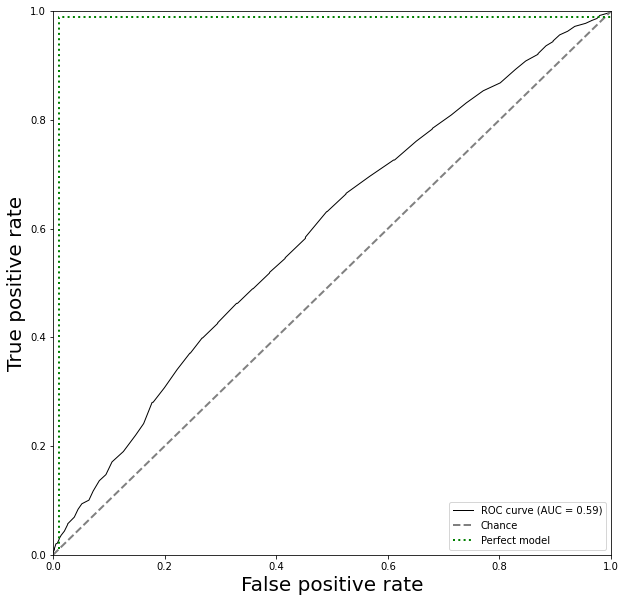

In [17]:
get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))

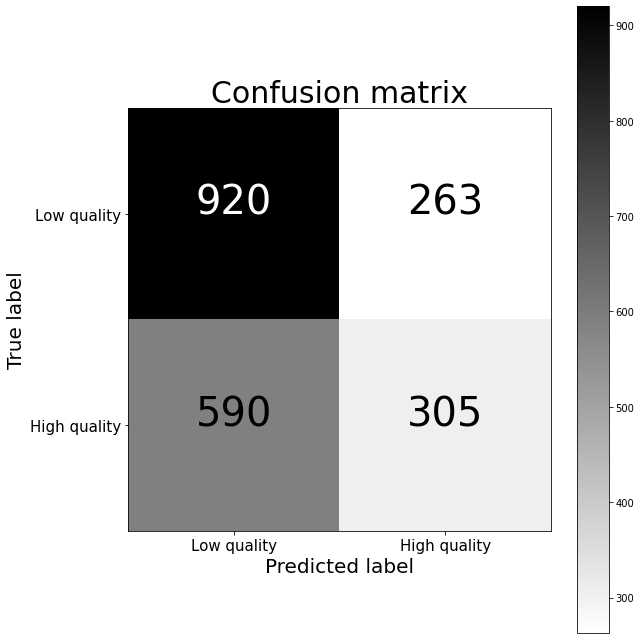

In [18]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


	Brier: 0.240


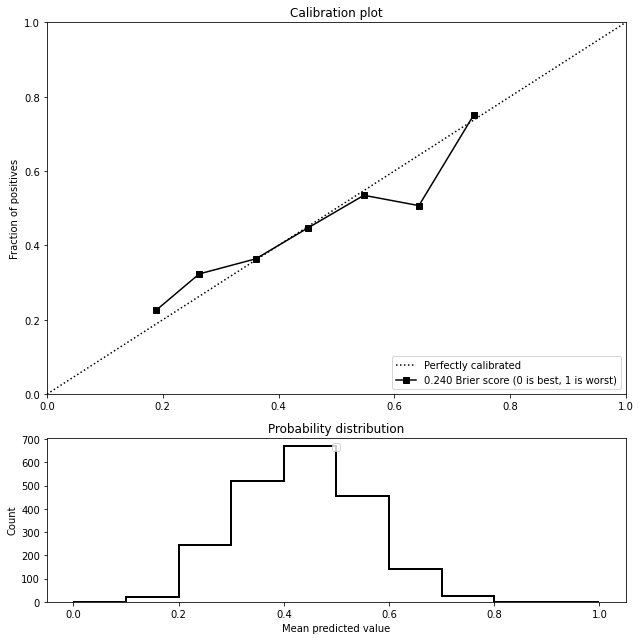

In [19]:
get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))

세번째 모델은 이해하기 쉬운 특성만을 사용하고 이전 모델보다 더 보정이 잘 되어 있다. 모델간의 비교는(comparing_model.ipynb) 노트북을 참고한다.

# 추론 함수

이전 두 개의 모델과 마찬가지로 임의의 질문을 받고 높은 점수를 받을 추정 확률을 출력하는 추론 함수를 정의한다.

In [20]:
pos_prob = get_question_score_from_input("""
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
""")

print("%s probability of the question receiving a high score according to our model" % (pos_prob))

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]

0.26 probability of the question receiving a high score according to our model
